Based on the

[1]: Option Pricing using Quantum Computers, N. Stamatopoulos et al., 2000, https://arxiv.org/abs/1905.02666

[2]: A new quantum ripple-carry addition circuit, S. A. Cuccaro et al., 2008, https://arxiv.org/abs/quant-ph/0410184
***

# Integer comparison using quantum circuit

This notebook features a quantum circuit that can be used to compare two integers. The comparator circuit takes input value $C$, and compares it to value $N$ encoded into qubit register. The result of comparison is encoded into the single comparison qubit, 0 if $N \leqslant C$ and 1 if $N > C$. 

### Imports

In [1]:
import numpy as np

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute

pi=np.pi

### Choosing backend simulator

Can be run on

1) Noise-free simulators, such as Qiskit Aer.
2) Noisy simulators, for example IQMFakeAdonis with noise profile correspoding to Helmi Quantum computer. (Amount of available qubits limited by the choice of noise profile)
3) On real quantum computer, such as Helmi. Note that this requires access to the quantum computer. (Qubits again limited by the choice of hardware)

Backends used in this notebook are chosen in the cell below.

In [2]:
from qiskit import Aer
from iqm.qiskit_iqm import IQMFakeAdonis, IQMProvider
import os


#UNCOMMENT YOUR CHOICE OF BACKEND
#Noiseless simulator----------------------------------------------
#backend_simulator = Aer.get_backend('aer_simulator_statevector')
#-----------------------------------------------------------------

#Fake simulating Helmi--------------------------------------------
#backend_simulator = IQMFakeAdonis()
#-----------------------------------------------------------------

#Helmi quantum computer (Requires connection)---------------------
HELMI_CORTEX_URL = os.getenv('HELMI_CORTEX_URL')
provider = IQMProvider(HELMI_CORTEX_URL)
backend_simulator = provider.get_backend()
#-----------------------------------------------------------------

### Encode integer into the qubits

The function takes an `number` and encodes it into the `m` qubits by flipping the qubit if the corresponding bit has a value 1. The qubits must be initially in a state $|0\rangle$. Note that `bits` must be large enough for the binary representation. The number is rounded upwards if it's not integer.

In [3]:
def Encode_integer(m, number):
    if np.floor(np.log2(number)) + 1 > m:
         raise ValueError(f"Not enough qubits ({m}) for this choice of integer ({number}) .")
    circ = QuantumCircuit(m)
    binary = np.binary_repr(int(np.ceil(number)), m)
    bits = [int(x) for x in reversed(binary)]
    for i, k in enumerate(bits):
        if (k == 1):
            circ.x(i)
    return circ

### Twos complement

Function for calculating binary representation of the twos complement of a number, represented with `bits` bits, and again returned in reversed order.

In [4]:
def Twos_complement(number, bits):
    if np.floor(np.log2(number)) + 1 > bits:
         raise ValueError(f"Not enough qubits ({bits}) for this choice of integer ({number}) .")
    # np.binary_repr return the binary representaion of the twos complement of the input, if the input is negative
    temp = np.binary_repr(-int(np.ceil(number)), bits)
    value = []
    for i in reversed(range(len(temp))):
        if temp[i]=='1':
            value.append(1)
        else:
            value.append(0)
    return value

### OR-gate

Quantum simulated logical OR-gate. If either of the control qubits are in the $|1\rangle$, the target qubit is set to state $|1\rangle$

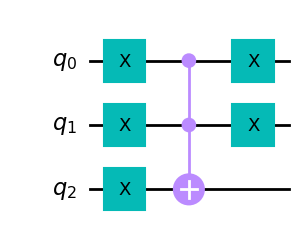

In [5]:
def Build_OR():
    circ = QuantumCircuit(3)
    circ.x(range(3))
    circ.ccx(0,1,2)
    circ.x(range(2))
    return circ

OR = Build_OR()

OR.draw('mpl', style="clifford")

### Comparator circuit

The linear depth comparator circuit performs bitwise comparison between qubit register and integer $C$.
If the qubit register has size $m$, the circuit uses additional $m$ ancilla qubits, and one comparison qubit which holds the result. Note that it must be possible to represent $C$ using $m$ binary numbers.

The comparison uses CNOT, Toffoli, and logical OR-gates. The exact structure of the circuit depends on the bitwise comparison of the integer $C$ and the qubit register.
The result of the comparison ends up in the last ancilla qubit, from which it is encoded into the comparison qubit using the CNOT-gate. The ancillas are then uncomputed, which is required if this circuit is to be used as a part of any algorithms.

The circuit is based on the ripple-carry approach. Further details of the implementation in [1] and [2].


In [6]:
def Build_comparator(m, C):
    OR = Build_OR().to_gate(label='OR')
    circ = QuantumCircuit(m+m+1)
    #C is compared to the positive number, so comparison is not necessary for negative C
    if C <= 0:
        circ.x(m+m)
        return circ
    t = Twos_complement(C, m)
    #Encoding results of comparison into ancilla qubits
    if t[0]==1:
        circ.cx(0, m)
    for i in range(1,m):
        if t[i]==0:
            circ.ccx(i, i+m-1, i+m)
        else:
            circ.append(OR, list((i, i+m-1, i+m)))
    #Setting comparison qubit with CNOT-gate
    circ.cx(m+m-1, m+m)
    #Uncomputing ancillas
    for i in reversed(range(1,m)):
        if t[i]==0:
            circ.ccx(i, i+m-1, i+m)
        else:
            circ.append(OR, list((i, i+m-1, i+m)))
    if t[0]==1:
        circ.cx(0, m)
    return circ

### Example

Testing the circuit by comparing two integers. 

1) `m_qbits` is the size of the qubit register. Total qubits will be `2*m_qbits+1`
2) `N` is the integer encoded into the qubit register
3) `C` is the integer we compare the quit register

In [7]:
m_qbits = 2     #Total qubits will be 2*m_qbits+1
N = 3
C = 2

In [8]:
q_req = QuantumRegister(m_qbits, 'q')
anc_req = QuantumRegister(m_qbits, 'anc')
cmp_req = QuantumRegister(1, 'cmp')
classical_req = ClassicalRegister(1, 'classical')
qc = QuantumCircuit(q_req, anc_req, cmp_req, classical_req)

P = Encode_integer(m_qbits, N).to_gate(label='  P  ')
comparator = Build_comparator(m_qbits, C).to_gate(label='  CMP  ')

qc.append(P, q_req)
qc.barrier()
qc.append(comparator, range(2*m_qbits + 1))
qc.barrier()
qc.measure(cmp_req, classical_req)

job = execute(qc, backend_simulator, shots=1)
counts = job.result().get_counts()
result = int(list(counts.keys())[0])

print()
print(f"N = {N}")
print(f"C = {C}")
print(f"Measured comparison qubit = {result}")
print()
if(result == 0):
    print(f"Result: {N} is smaller than {C}")
if(result == 1):
    print(f"Result: {N} is larger or equal to {C}")


N = 3
C = 2
Measured comparison qubit = 1

Result: 3 is larger or equal to 2


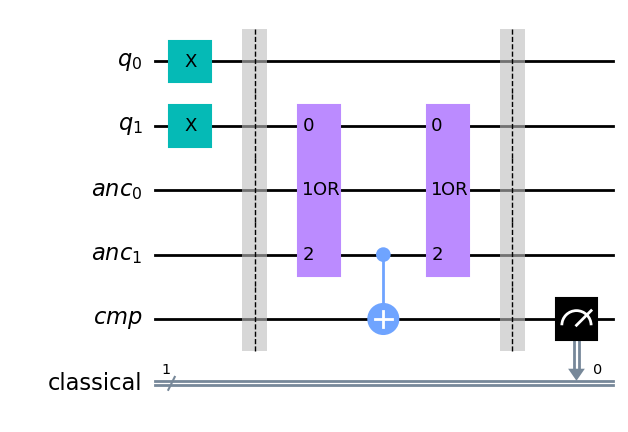

In [9]:
qc.decompose().draw('mpl', style="clifford")

For further use, note that the CNOT operation on the comparison qubit can be combined with two 'lowest' gates, which act on the last ancilla. Thus the comparison circuit can be implemented with $m-1$ ancillas.